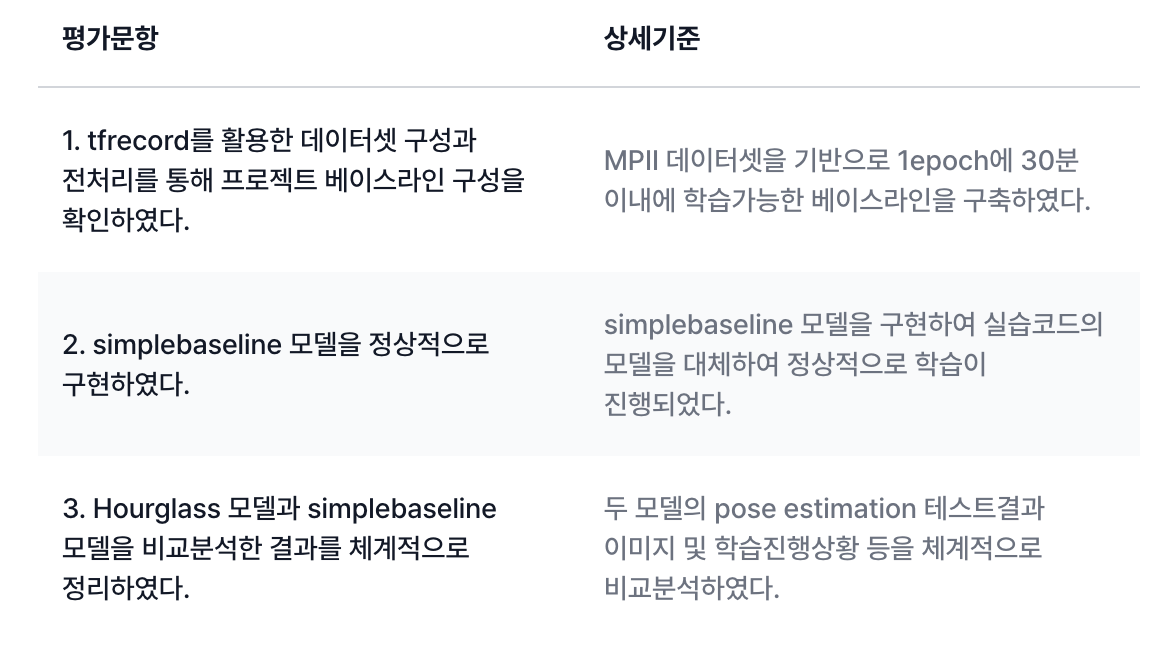

# 데이터 전처리하기

In [6]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
# OSError: Read-only file system
# MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
MODEL_PATH = os.path.join(PROJECT_PATH, 'model')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

print('슝=3')

슝=3


In [2]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


- joints 순서는 아래와 같은 순서로 배치되어 저장

- 0 - 오른쪽 발목
- 1 - 오른쪽 무릎
- 2 - 오른쪽 엉덩이
- 3 - 왼쪽 엉덩이
- 4 - 왼쪽 무릎
- 5 - 왼쪽 발목
- 6 - 골반
- 7 - 가슴(흉부)
- 8 - 목
- 9 - 머리 위
- 10 - 오른쪽 손목
- 11 - 오른쪽 팔꿈치
- 12 - 오른쪽 어깨
- 13 - 왼쪽 어깨
- 14 - 왼쪽 팔꿈치
- 15 - 왼쪽 손목

###  json annotation 을 파싱하는 함수

In [3]:
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

print('슝=3')

슝=3


In [4]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


# TFRecord 파일 만들기

### 앞서 추출한 annotation을 TFRecord로 변환하는 함수

In [5]:
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

print('슝=3')

슝=3


### 얼마나 많은 TFRecord를 만들지 결정할 함수

In [6]:
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

test_chunks = chunkify([0] * 1000, 64)
print('test_chunks',test_chunks)
print(len(test_chunks))
print(len(test_chunks[0]))

test_chunks [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 

### 하나의 chunk를 TFRecord로 만들어 줄 함수

In [7]:
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

print('슝=3')

슝=3


### 전체 데이터를 적당한 수의 TFRecord 파일로 만들어주는 함수

In [8]:
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

print('슝=3')

슝=3


# Ray

앞서 작성한 함수를 사용해 데이터를 TFRecord로 만들어 줍니다. 
- train 데이터는 64개로, 
- val 데이터는 8개의 파일로 만듭니다.

In [9]:
num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

2024-10-30 15:50:24,249	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.85gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/aiffel/aiffel/mpii/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'c

# data label 로 만들기

TFRecord로 저장된 데이터를 모델 학습에 필요한 데이터로 바꿔줄 함수
- TFRecord가 직렬화된 데이터
- 데이터 순서와 읽어올 때 데이터 순서가 같아야 한다
- 데이터의 형식도 동일하게 맞춰 줘야 합니다.

In [10]:
# def parse_tfexample(example):
#     image_feature_description = {
#         'image/height': tf.io.FixedLenFeature([], tf.int64),
#         'image/width': tf.io.FixedLenFeature([], tf.int64),
#         'image/depth': tf.io.FixedLenFeature([], tf.int64),
#         'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
#         'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
#         'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
#         'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
#         'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
#         'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
#         'image/encoded': tf.io.FixedLenFeature([], tf.string),
#         'image/filename': tf.io.FixedLenFeature([], tf.string),
#     }
#     return tf.io.parse_single_example(example, image_feature_description)

# print('슝=3')

- 이미지를 그대로 사용하지 않고 적당히 정사각형으로 crop하여 사용
- 임의로 조정한 crop box 가 이미지 바깥으로 나가지 않는지 예외 처리를 잘 해주어야 한다

In [11]:
# def crop_roi(image, features, margin=0.2):
#     img_shape = tf.shape(image)
#     img_height = img_shape[0]
#     img_width = img_shape[1]
#     img_depth = img_shape[2]

#     keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
#     keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
#     center_x = features['image/object/center/x']
#     center_y = features['image/object/center/y']
#     body_height = features['image/object/scale'] * 200.0

#     # keypoint 중 유효한값(visible = 1) 만 사용합니다.
#     masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
#     masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

#     # min, max 값을 찾습니다.
#     keypoint_xmin = tf.reduce_min(masked_keypoint_x)
#     keypoint_xmax = tf.reduce_max(masked_keypoint_x)
#     keypoint_ymin = tf.reduce_min(masked_keypoint_y)
#     keypoint_ymax = tf.reduce_max(masked_keypoint_y)

#     # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
#     xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
#     xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
#     ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
#     ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

#     # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
#     effective_xmin = xmin if xmin > 0 else 0
#     effective_ymin = ymin if ymin > 0 else 0
#     effective_xmax = xmax if xmax < img_width else img_width
#     effective_ymax = ymax if ymax < img_height else img_height
#     effective_height = effective_ymax - effective_ymin
#     effective_width = effective_xmax - effective_xmin

#     image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
#     new_shape = tf.shape(image)
#     new_height = new_shape[0]
#     new_width = new_shape[1]

#     effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
#     effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

#     return image, effective_keypoint_x, effective_keypoint_y

# print('슝=3')

(build_single_tfrecord pid=896) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/val_0008_of_0008.tfrecords


### 확률 분포(2차원 가우시안 분포) 형태의 정보를 heatmap

In [12]:
# def generate_2d_guassian(height, width, y0, x0, visibility=2, sigma=1, scale=12):
#     heatmap = tf.zeros((height, width))

#     xmin = x0 - 3 * sigma
#     ymin = y0 - 3 * sigma
#     xmax = x0 + 3 * sigma
#     ymax = y0 + 3 * sigma
    
#     if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
#         return heatmap

#     size = 6 * sigma + 1
#     x, y = tf.meshgrid(tf.range(0, 6 * sigma + 1, 1), tf.range(0, 6 * sigma + 1, 1), indexing='xy')

#     center_x = size // 2
#     center_y = size // 2

#     gaussian_patch = tf.cast(tf.math.exp(
#         -(tf.math.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale,
#                              dtype=tf.float32)

#     patch_xmin = tf.math.maximum(0, -xmin)
#     patch_ymin = tf.math.maximum(0, -ymin)
#     patch_xmax = tf.math.minimum(xmax, width) - xmin
#     patch_ymax = tf.math.minimum(ymax, height) - ymin

#     heatmap_xmin = tf.math.maximum(0, xmin)
#     heatmap_ymin = tf.math.maximum(0, ymin)
#     heatmap_xmax = tf.math.minimum(xmax, width)
#     heatmap_ymax = tf.math.minimum(ymax, height)

#     indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
#     updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

#     count = 0

#     for j in tf.range(patch_ymin, patch_ymax):
#         for i in tf.range(patch_xmin, patch_xmax):
#             indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
#             updates = updates.write(count, gaussian_patch[j][i])
#             count += 1

#     heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

#     return heatmap

# def make_heatmaps(features, keypoint_x, keypoint_y, heatmap_shape):
#     v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
#     x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
#     y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)

#     num_heatmap = heatmap_shape[2]
#     heatmap_array = tf.TensorArray(tf.float32, 16)

#     for i in range(num_heatmap):
#         gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
#         heatmap_array = heatmap_array.write(i, gaussian)

#     heatmaps = heatmap_array.stack()
#     heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])  # change to (64, 64, 16)

#     return heatmaps

# print('슝=3')

### 객체 형태로 조합

In [46]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)

print('슝=3')

슝=3


# 모델을 학습

## Hourglass 모델 만들기

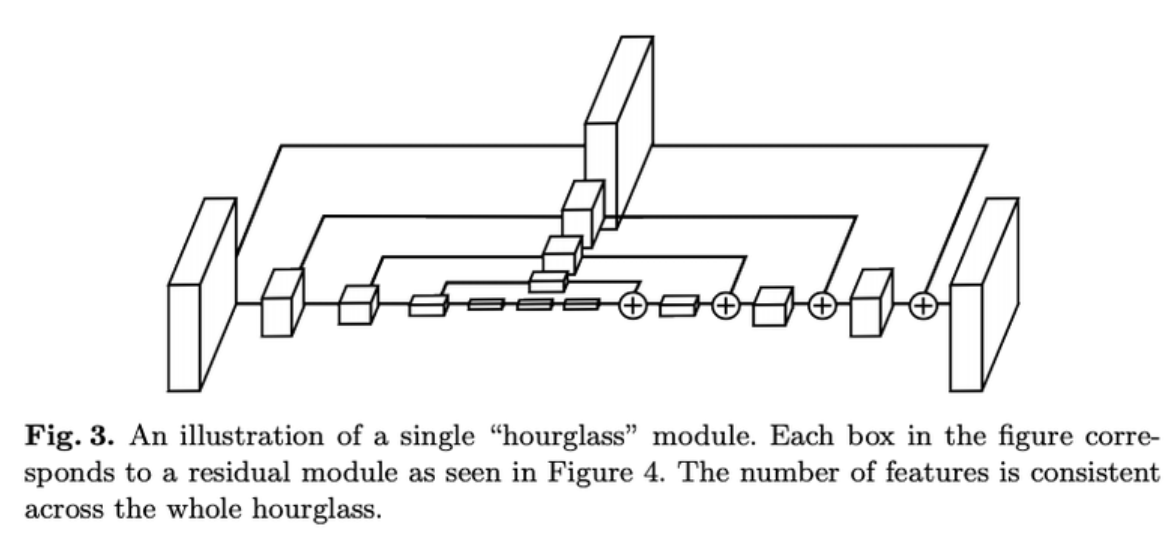

### residual block

In [12]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

print('슝=3')

슝=3


In [14]:
def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

print('슝=3')

슝=3


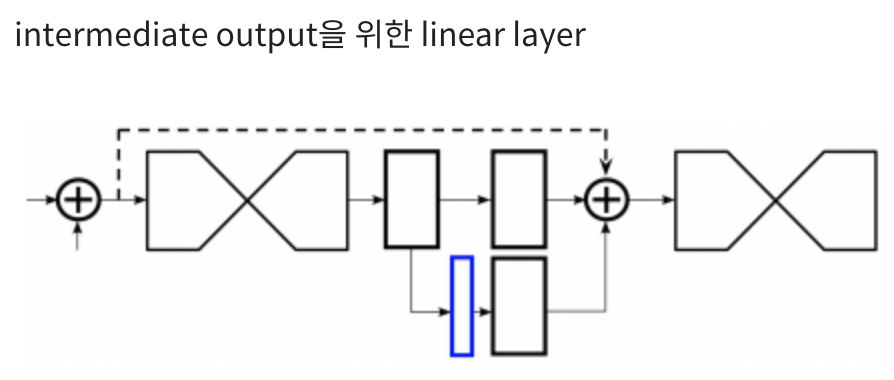

In [16]:
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

print('슝=3')

슝=3


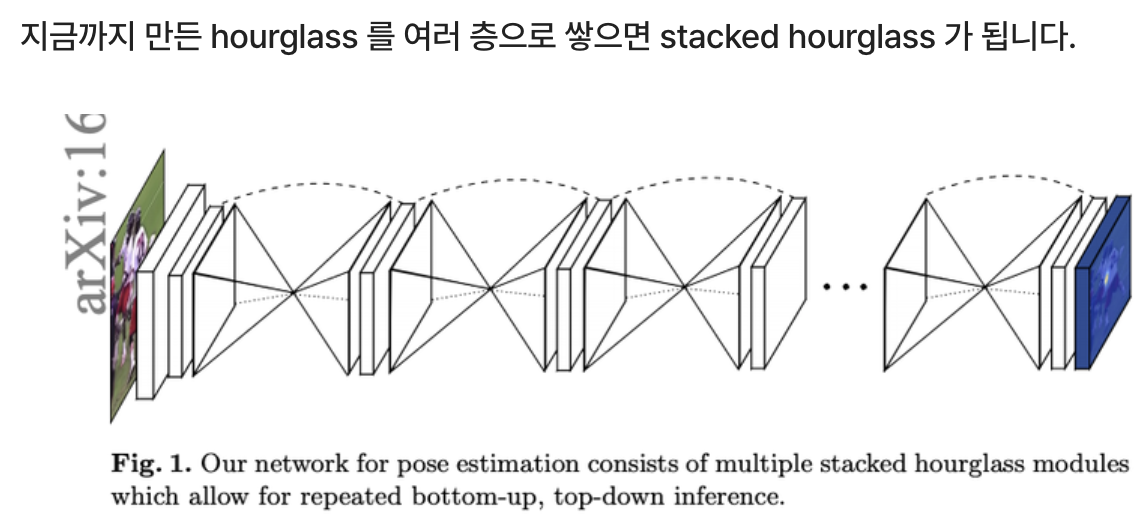

In [8]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

print('슝=3')

슝=3


# 학습 엔진 만들기

## GPU가 여러 개인 환경

- tf.distribute.MirroredStrategy :  GPU가 여러 개인 경우 사용할 수 있는 방법
    - 여러 GPU가 모델을 학습한 후 각각의 Loss를 계산하면 CPU가 전체 Loss를 종합
- strategy.reduce : 각 GPU에서 계산한 Loss를 토대로 전체 Loss를 종합해주는 역할

In [50]:
import time

class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate,
                 csv_log_path):  # CSV 로그 경로 추가
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None
        
        self.csv_log_path = csv_log_path 

        # CSV 파일 생성 및 헤더 작성
        with open(self.csv_log_path, 'w', newline='') as csvfile:
            csv_writer = csv.writer(csvfile)
            csv_writer.writerow(['Epoch', 'Learning Rate', 'Train Loss', 'Val Loss', 'Epoch Duration (s)'])


    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
#         loss = 0
        # 명시적으로 float32 타입으로 초기화
        loss = tf.constant(0.0, dtype=tf.float32)
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):

            start_time = time.time() # 시간측정 추가            
            
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            
            epoch_duration = time.time() - start_time # 시간측정 추가
            
            print('Epoch {} val loss {}'.format(epoch, val_loss))
            
            # CSV 파일에 기록
            with open(self.csv_log_path, 'a', newline='') as csvfile:
                csv_writer = csv.writer(csvfile)
                csv_writer.writerow([epoch, self.current_learning_rate, train_loss, val_loss, epoch_duration])

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss
            

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = MODEL_PATH + '/model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

print('슝=3')

슝=3


### 데이터셋을 만드는 함수
- TFRecord 파일이 여러개이므로 tf.data.Dataset.list_files를 통해 불러옵니다.

In [10]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

print('슝=3')

슝=3


In [20]:
def train(epochs, 
          learning_rate, 
          num_heatmap, 
          batch_size, 
          train_tfrecords, 
          val_tfrecords,
          csv_log_path):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope(): # 반드시 필요한 부분
        # experimental_distribute_dataset 를 통해 데이터셋 연결
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate,
            csv_log_path=csv_log_path)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

print('슝=3')

슝=3


# 학습 

In [21]:
'''
INFO:tensorflow:Using MirroredStrategy with devices 
('/job:localhost/replica:0/task:0/device:GPU:0',)
-> 현재 학습이 로컬에서 실행되며, 하나의 GPU가 연결되어 있음을 보여줍니다.
'''

"\nINFO:tensorflow:Using MirroredStrategy with devices \n('/job:localhost/replica:0/task:0/device:GPU:0',)\n-> 현재 학습이 로컬에서 실행되며, 하나의 GPU가 연결되어 있음을 보여줍니다.\n"

In [ ]:
import csv

train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5
# batch_size = 16
batch_size = 8
num_heatmap = 16
learning_rate = 0.0007
# learning_rate = 0.01


best_model_file = train(epochs, 
                        learning_rate, 
                        num_heatmap, 
                        batch_size, 
                        train_tfrecords, 
                        val_tfrecords,
                        csv_log_path="./training_log.csv"
                       )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 1 batch loss 5.24251795 epoch total loss 5.24251795
Trained batch 2 batch loss 4.88277626 epoch total loss 5.06264687
Trained batch 3 batch loss 4.85261393 epoch total loss 4.99263573
Trained batch 4 batch loss 4.70427608 epoch total loss 4.92054558
Trained batch 5 batch loss 4.23125267 epoch total loss 4.78268719
Trained batch 6 batch loss 4.74029636 epoch total loss 4.77562189
Trained batch 7 batch loss 4.74224567 epoch total loss 4.770854
Trained batch 8 batch loss 4.7030654 epoch total loss 4.76238
Trained batch 9 batch loss 4.42281294 epoch total loss 4.72465038
Trained batch 10 batch loss 4.33714581 epoch total loss 4.6859
Trained batch 11 batch loss 4.56461811 epoch total loss 4.67487431
Trained batch 12 batch loss 4.30529594 epoch total loss 4.64407587
Trained batch 13 batch loss 4.48834896 epoch total loss 4.63209724
Trained batch 14 batch loss 4.16661406 epoch total loss 4.59884787
Trained batch 15 batch loss 4.46651125 epoch total

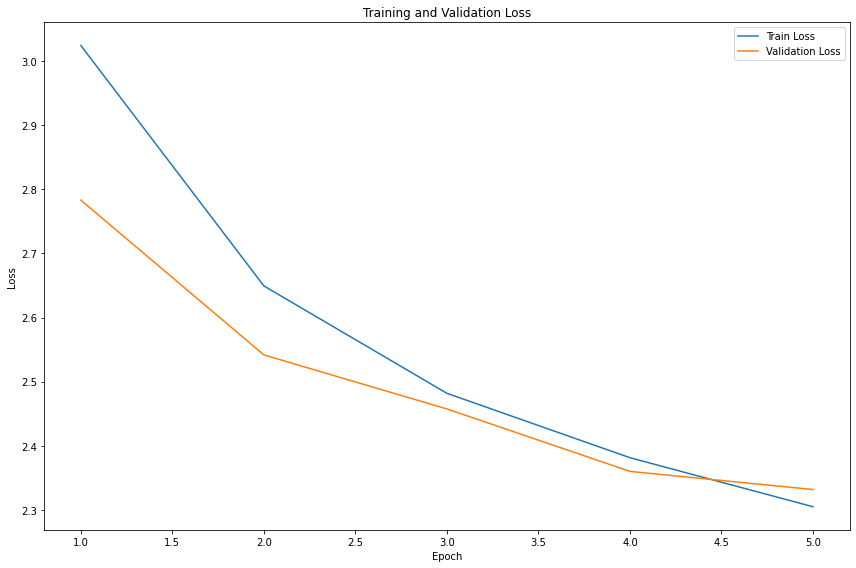

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 경로
log_path = "./training_log.csv"

# CSV 파일 읽기
log_data = pd.read_csv(log_path)

# 텐서 데이터를 문자열에서 추출하여 float 값으로 변환
log_data['Train Loss'] = log_data['Train Loss'].str.extract(r'(\d+\.\d+)').astype(float)
log_data['Val Loss'] = log_data['Val Loss'].str.extract(r'(\d+\.\d+)').astype(float)
log_data['Learning Rate'] = log_data['Learning Rate'].astype(float)

# 그래프 크기 설정
plt.figure(figsize=(12, 8))

# Training & Validation Loss 시각화
plt.subplot(1, 1, 1)
plt.plot(log_data['Epoch'], log_data['Train Loss'], label='Train Loss')
plt.plot(log_data['Epoch'], log_data['Val Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()


In [36]:
print(log_data)

   Epoch  Learning Rate  Train Loss  Val Loss  Epoch Duration (s)
0      1         0.0007    3.024412  2.783194         1645.658781
1      2         0.0007    2.649338  2.541689         1500.275936
2      3         0.0007    2.481825  2.457435         1512.819621
3      4         0.0007    2.381374  2.360055         1524.963120
4      5         0.0007    2.304895  2.331722         1515.966255


# 예측 엔진 만들기

In [19]:
WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'models', 'model-v0.0.1-epoch-2-loss-1.3072.h5')

model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
model.load_weights(WEIGHTS_PATH)

# 이전의 학습하는 코드 블럭을 통해 학습하고 그 모델을 사용할 경우 아래 주석 처리된 코드를 사용하면 됩니다
# model.load_weights(best_model_file)

- 학습에 사용했던 keypoint 들을 사용해야 하기 때문에 필요한 변수를 지정
- 변수에 저장되는 것은 해당 부위를 나타내는 인덱스예요.

In [20]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

print('슝=3')

슝=3


### heatmap에서 최대값을 찾는 함수
- 모델을 학습할 때 라벨이 되는 좌표를 heatmap으로 바꿨던 것이 기억 나시나요?
- 학습을 heatmap으로 했기 때문에 모델이 추론해 내놓은 결과도 heatmap
- 이 heatmap으로부터 좌표를 추출
- heatmap중에 최대값을 갖는 지점을 찾아내면 되겠네요.

In [21]:
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

print('슝=3')

슝=3


- 위 함수만으로는 256x256 이미지에 64x64 heatmap max 값을 표현할 때 
- quantization 오차가 발생하기 때문에 
- 실제 계산에서는 3x3 필터를 이용해서 근사치를 구해줍니다.

In [22]:
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

print('슝=3')

슝=3


### 모델과 이미지 경로를 입력하면 이미지와 keypoint를 출력하는 함수

In [23]:
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

print('슝=3')

슝=3


### 그림만 그려주면 완성
- 그림을 그릴 때는 두 가지 그림을 그려볼 겁니다.
- keypoint들과 뼈대
- keypoint들은 관절 역할을 하고 
- keypoint들을 연결시킨 것이 뼈대가 되겠네요.

In [24]:
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

print('슝=3')

슝=3


### model-v0.0.1-epoch-2-loss-1.3072.h5 

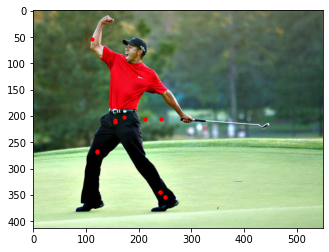

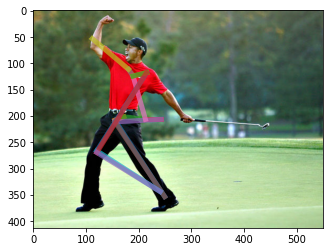

In [25]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

### model-epoch-5-loss-2.3317.h5

In [26]:
WEIGHTS_PATH_epoch5 = os.path.join(PROJECT_PATH, 'model', 'model-epoch-5-loss-2.3317.h5')

epoch5_model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
epoch5_model.load_weights(WEIGHTS_PATH_epoch5)

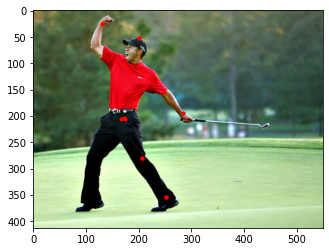

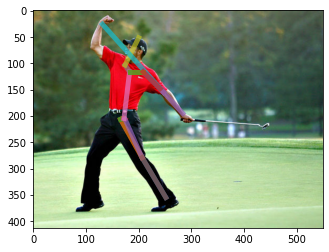

In [27]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(epoch5_model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

### 결과비교
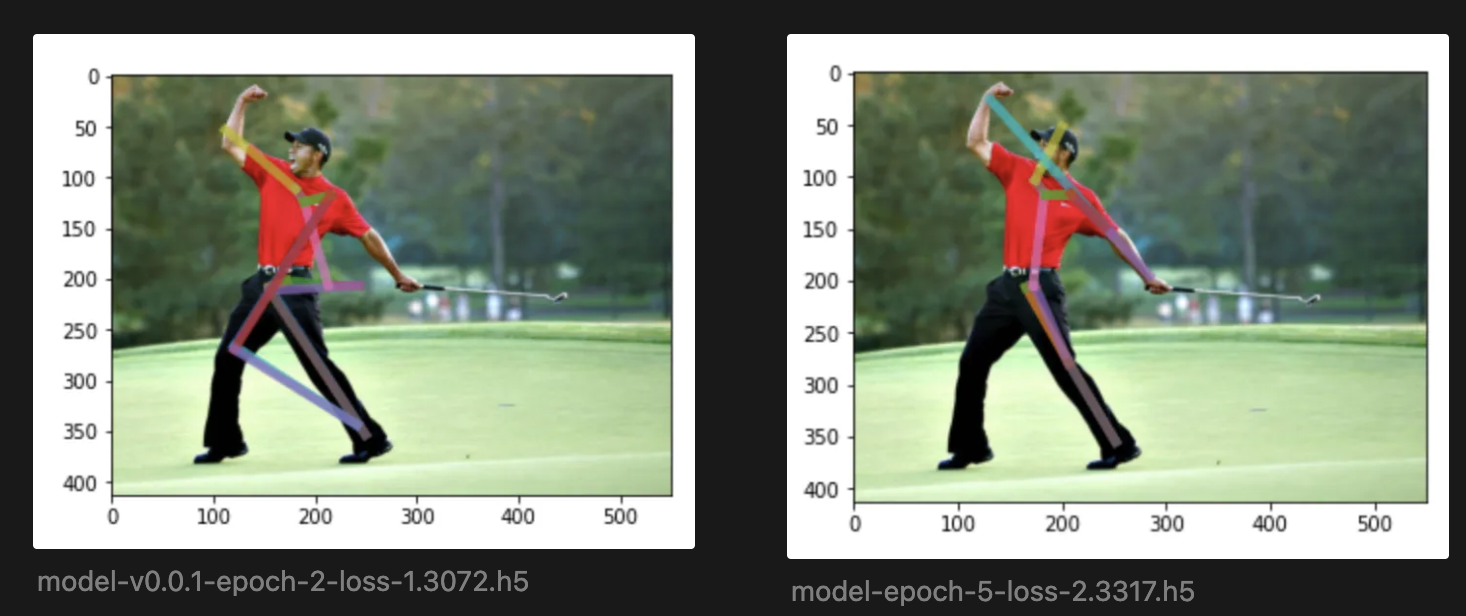
- epoch2번 돌린 왼쪽에 비해 epoch5 돌린 모델의 성능이 다르긴 하나 성능이 확연히 좋아졌다는 모르겠다
- 예를 들어 왼쪽 그림에서는 왼쪽 다리, 오른쪽 팔을 잘 탐지 했고
- 오른쪽 그림에서는 왼쪽 다리, 왼쪽 팔을 잘 탐지 했다.
- 그러나 동일하게 오른쪽 다리는 잘 탐지하지 못했다.
- 정성적 결과 외에 정량적 평가도 필요할듯

# STEP 1 : simplebaseline 모델 완성하기

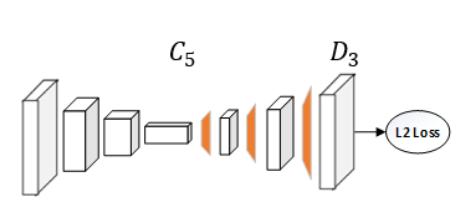

In [41]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, ReLU, Input
from tensorflow.keras.models import Model


def _make_deconv_layer(num_deconv_layers=3):
    seq_model = tf.keras.models.Sequential()
    for _ in range(num_deconv_layers):
        seq_model.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'))
        seq_model.add(BatchNormalization())
        seq_model.add(ReLU())
    return seq_model

def Simplebaseline(input_shape=(256, 256, 3), num_heatmap=16):
    inputs = Input(shape=input_shape)
    
    # ResNet backbone
    x = resnet(inputs)
    
    # 이게 여기 없으면 에러
    resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')
    
    # Deconvolution layers
    upconv = _make_deconv_layer(3)
    x = upconv(x)
    
    # Final output layer
    out = Conv2D(num_heatmap, kernel_size=1, strides=1, padding='same', name='output_heatmap')(x)
    
    model = Model(inputs, out, name='simple_baseline')
    return model


In [42]:
# 모델 생성
simple_baseline_model = Simplebaseline()
simple_baseline_model.summary()

Model: "simple_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
sequential_3 (Sequential)    (None, 64, 64, 256)       10489600  
_________________________________________________________________
output_heatmap (Conv2D)      (None, 64, 64, 16)        4112      
Total params: 34,081,424
Trainable params: 34,026,768
Non-trainable params: 54,656
_________________________________________________________________


# STEP 2 : simplebaseline 모델로 변경하여 훈련하기

- StackedHourglass를 학습시킨 코드의 모델 선언 부분을 simplebaseline 모델로 변경한 후 다시 학습을 진행합니다.

In [44]:
def train(epochs, 
          learning_rate, 
          num_heatmap, 
          batch_size, 
          train_tfrecords, 
          val_tfrecords,
          csv_log_path):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():  # 반드시 필요한 부분
        # experimental_distribute_dataset 를 통해 데이터셋 연결
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        # 모델을 Simplebaseline으로 변경
        ㄴmodel = Simplebaseline(input_shape=IMAGE_SHAPE, num_heatmap=num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate,
            csv_log_path=csv_log_path)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

print('슝=3')


슝=3


In [52]:
'''
Error 
Make sure the slot variables are created under the same strategy scope. This may happen if you're restoring from a checkpoint outside the scope

Solve
MirroredStrategy를 사용하는 분산 학습 과정에서 변수와 옵티마이저가 서로 다른 스코프에서 생성될 때 발생하는 문제
변수와 옵티마이저가 동일한 strategy.scope() 내에서 생성되지 않아서 발생
'''

"\nError \nMake sure the slot variables are created under the same strategy scope. This may happen if you're restoring from a checkpoint outside the scope\n\nSolve\nMirroredStrategy를 사용하는 분산 학습 과정에서 변수와 옵티마이저가 서로 다른 스코프에서 생성될 때 발생하는 문제\n변수와 옵티마이저가 동일한 strategy.scope() 내에서 생성되지 않아서 발생\n"

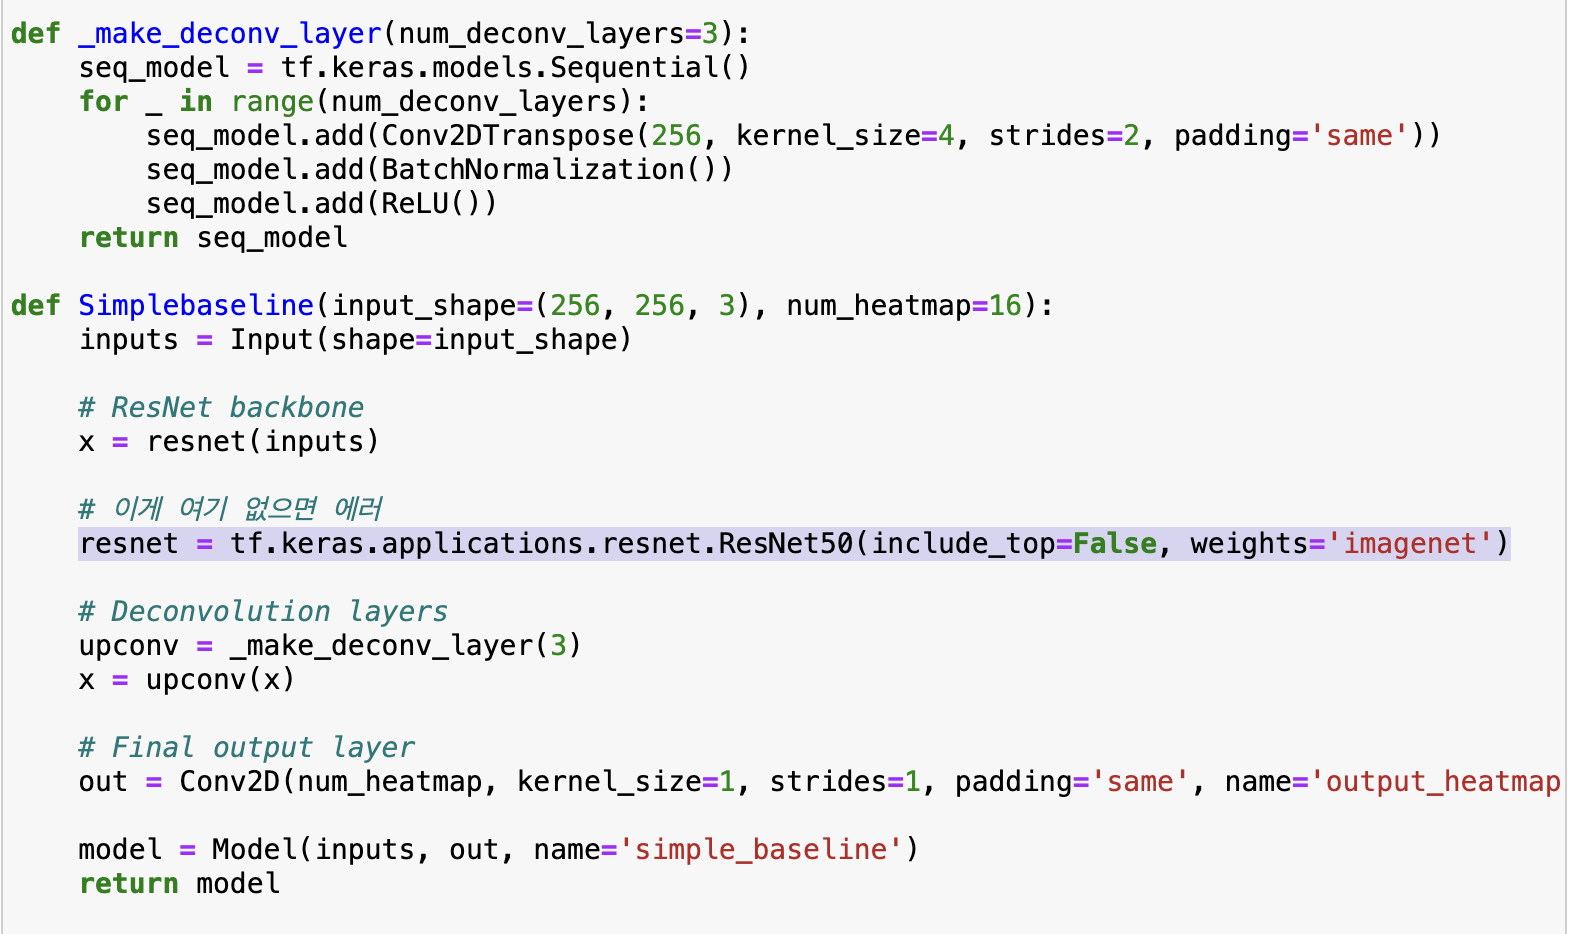

In [ ]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5
# batch_size = 16
batch_size = 8
num_heatmap = 16
learning_rate = 0.0007
# learning_rate = 0.01


simple_model_file = train(epochs, 
                        learning_rate, 
                        num_heatmap, 
                        batch_size, 
                        train_tfrecords, 
                        val_tfrecords,
                        csv_log_path="./simple_training_log.csv"
                       )

# STEP 3 : 두 모델의 비교

- Pose Estimation 결과 시각화 (정성적 비교)
- 학습 진행 경과 (loss 감소 현황)
- 가급적 두 모델 모두 최소 3epoch 이상, (5epoch 이상 권장)을 학습하기 바랍니다

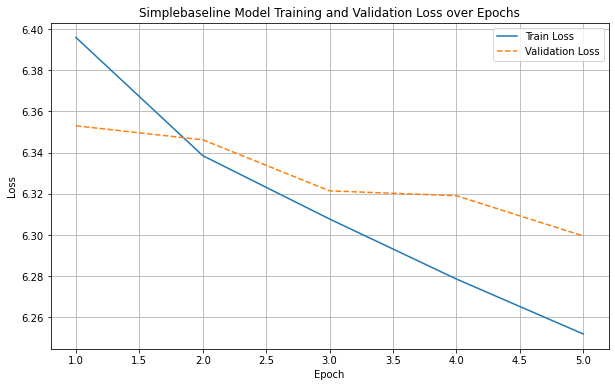

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# simple_training_log 파일을 불러옵니다.
simple_training_log = './simple_training_log.csv'
training_log = pd.read_csv(simple_training_log)

# 'Train Loss'와 'Val Loss' 열에서 숫자만 추출하여 float 형태로 변환합니다.
training_log['Train Loss'] = training_log['Train Loss'].str.extract(r"tf.Tensor\(([\d\.]+)").astype(float)
training_log['Val Loss'] = training_log['Val Loss'].str.extract(r"tf.Tensor\(([\d\.]+)").astype(float)

# Train Loss와 Validation Loss를 에포크에 따라 시각화합니다.
plt.figure(figsize=(10, 6))
plt.plot(training_log['Epoch'], training_log['Train Loss'], label='Train Loss')
plt.plot(training_log['Epoch'], training_log['Val Loss'], label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Simplebaseline Model Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


### 학습 비교

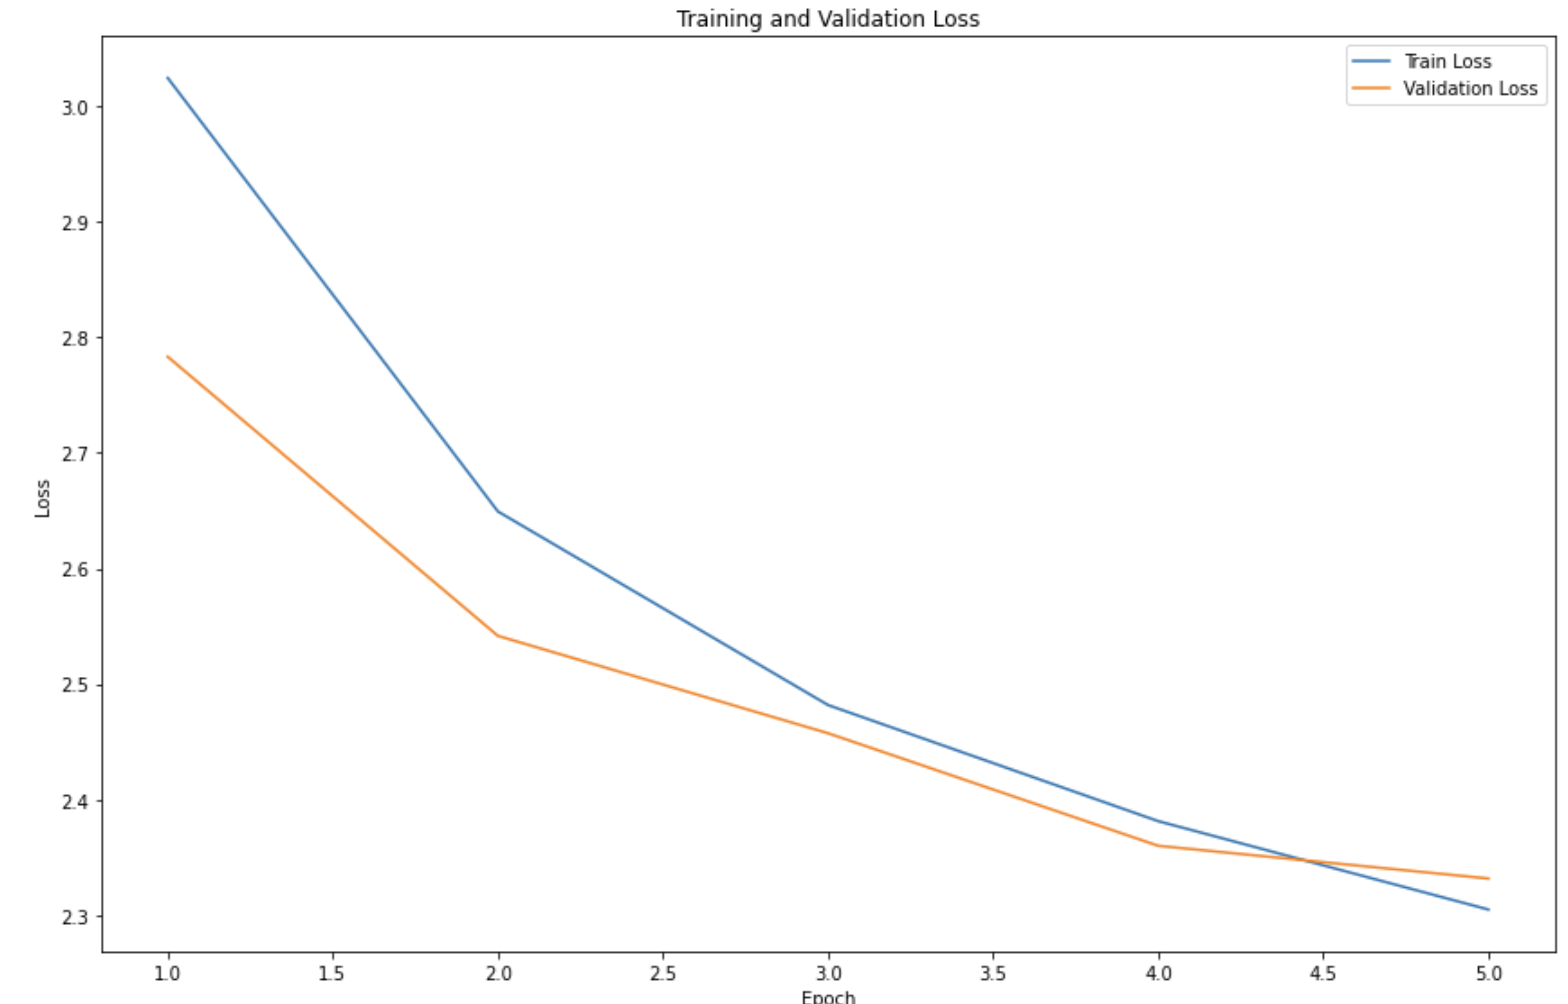 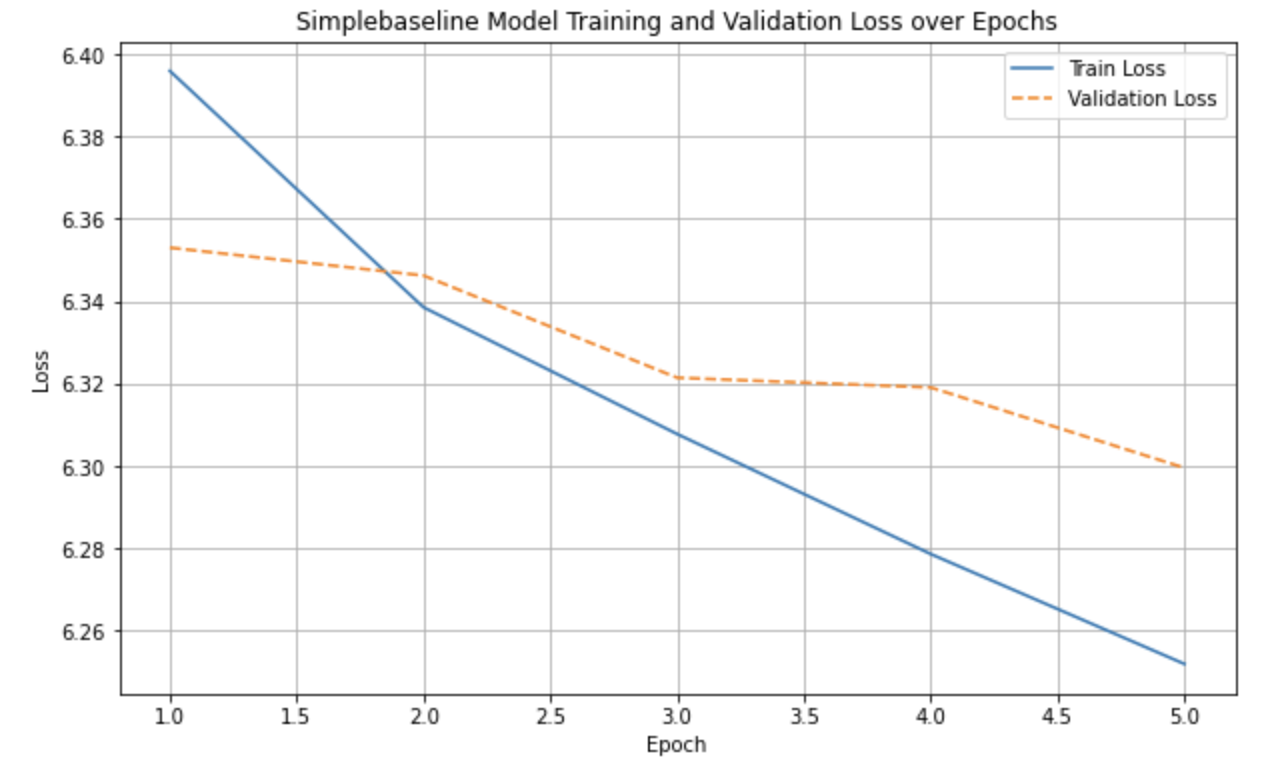

- simplebaselin model의 loss값이 더 높다
    - 5epocch : hourglass는 2.3~2.4, simplebasline은 6.25~6.30
- simplebasline은 val loss 보면 한참 더 학습 해야하나 싶은데 train loss보면 train data에 너무 과적합 되나 싶기도하고...